In [144]:
import pandas as pd
import xgboost as xgb
import shap
from data_prepper import DataPrepper
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import colorcet as cc
from matplotlib.lines import Line2D
import matplotlib.image as mpimg

In [145]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.rcParams["mathtext.fontset"] = "dejavusans"

In [146]:
filename = './results_final/combined_final.feather'
data = pd.read_feather(filename)
# dp = DataPrepper(filename)

In [147]:
features = ['x', 'y', 'z', 'Area', 'Zmin', 'Zmed', 'Zmax', 'Slope', 'dc_ratio', 'HI', 'sin_Aspect', 'cos_Aspect']
target = 'target'

In [148]:
# CN5O212A0282 Langmusang Glacier
rgiid1 = 15.10755
glacier1 = data[data['RGIId'] == rgiid1]

# Toshain Glacier
rgiid2 = 14.20157
glacier2 = data[data['RGIId'] == rgiid2]

In [149]:
glacier1_test = glacier1[glacier1['void_mask'] == True]
glacier2_test = glacier2[glacier2['void_mask'] == True]

In [150]:
shap_values1 = np.load('./shap/glacier1_shap.npy')
shap_values2 = np.load('./shap/glacier2_shap.npy')

In [151]:
# color_map_idx = {0: sns.color_palette('tab10')[0], 1: sns.color_palette('tab10')[1], 2: sns.color_palette('tab10')[2], 3: sns.color_palette('tab10')[3], 4: sns.color_palette('tab10')[4], 5: sns.color_palette('tab10')[5], 6: sns.color_palette('tab10')[6], 7: sns.color_palette('tab10')[7]}
color_map = {'x': sns.color_palette('tab10')[0], 'y': sns.color_palette('tab10')[1], 'z': sns.color_palette('tab10')[2], 'Area': sns.color_palette('tab10')[3], 'Zmin': sns.color_palette('tab10')[4], 'Zmed': sns.color_palette('tab10')[5], 'Zmax': sns.color_palette('tab10')[6], 'Slope': sns.color_palette('tab10')[7],}
cmap = {}
i = 0

for feature in features:
    cmap[feature] = sns.color_palette('tab10')[i % 10]
    i += 1
    
feature_names_read = {'x': '$x$', 
                      'y': '$y$', 
                      'z': '$z$', 
                      'Area': '$area$', 
                      'Zmin': '$z_{min}$', 
                      'Zmed': '$z_{med}$', 
                      'Zmax': '$z_{max}$',
                      'Slope': '$slope$',
                      'sin_Aspect': '$sin_{aspect}$',
                      'cos_Aspect': '$cos_{aspect}$',
                      'HI': '$HI$',
                      'dc_ratio': '$dc_{ratio}',     
}

In [168]:
def plot_spatial_shap_ehim(X_test, shap_values):
    """
    Plot the three features with maximum SHAP values at each spatial location
    
    Parameters:
    -----------
    X_test : pandas DataFrame
        Test data containing x and y coordinates
    shap_values : shap._explanation.Explanation
        SHAP values from explainer
    """

    # # Find indices of the three features with maximum absolute SHAP values at each point
    top2_shap_idx = np.argsort(np.abs(shap_values), axis=1)[:, -2:]

    fig, axes = plt.subplot_mosaic([['a)', 'b)'], ['a)', 'c)']], figsize = (20,10), width_ratios = [2.5,1.25], sharex = False, sharey = False, layout = 'constrained')

    for label, ax in axes.items():
        ax.set_title(label, fontfamily='sans-serif', loc='left', fontsize=16)

    
    ax0 = axes['a)']
    try:
        img = mpimg.imread('./figures/ehim_map_FINAL2.png')
    except FileNotFoundError:
        print("Image file not found. Please replace 'your_image.png' with a valid path to an image.")
        # Create a dummy image for demonstration if the file is not found
        img = np.random.rand(100, 100, 3)
    ax0.imshow(img)
    ax0.set_ymargin(-0.04)
    ax1 = axes['b)']
    ax2 = axes['c)']
    # print(img.shape)
    for i in range(2):
        if i == 0:
            ax = ax1
        else:
            ax = ax2
            
        feature_idx = top2_shap_idx[:, (1-i)]
        feature_values = np.array([shap_values[j, idx] for j, idx in enumerate(feature_idx)])
        feature_names = [features[idx] for idx in feature_idx]


        # Plot SHAP values
        # scatter1 = sns.scatterplot(x=X_test['x'], 
        #                             y=X_test['y'], 
        #                             hue=feature_values, 
        #                             ax=ax, 
        #                             palette='Greys',
        #                             # hue_norm=(-np.abs(feature_values).max(), np.abs(feature_values).max()),
        #                             s=50,
        #                             alpha=1,
        #                             edgecolor='none',
        #                             legend = False)
        
        # Plot feature with maximum impact
        scatter2 = sns.scatterplot(x=X_test['x'], 
                                    y=X_test['y'], 
                                    hue=feature_names, 
                                    ax=ax, 
                                    palette=cmap,
                                    s=50,
                                    alpha=0.75,
                                    edgecolor='none',
                                    hue_order = features,
                                    legend=False)
        
        legend_elements = [Line2D([0], [0], marker='o', color=cmap[feature], label=feature_names_read[feature], markerfacecolor=cmap[feature], markersize=10, linewidth = 0) for feature in features if feature in (set(feature_names))]
        ax.legend(handles = legend_elements, loc = 'upper right', prop={'size': 16})
        
        
    # ax0.set_title('Toshain (Rupal) Glacier, Western Himalaya')
    ax0.set_title('Langmusang Glacier, Eastern Himalaya', fontsize = 16)
    ax1.set_title('Highest SHAP value', fontsize = 16)
    ax2.set_title('Second highest SHAP value', fontsize = 16)
    
    ax1.set_xlabel('')
    ax2.set_xlabel('')
    ax1.set_ylabel('')
    ax2.set_ylabel('')
    ax1.set_xticks([])
    ax1.set_xticklabels([])
    ax1.set_yticks([])
    ax1.set_yticklabels([])
    ax2.set_xticks([])
    ax2.set_xticklabels([])
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    # plt.tight_layout()
    ax0.axis('off')
    # # plt.show()
    save = True
    if save:
        plt.savefig('./figures/ehim_shap_FINAL.png', bbox_inches='tight', dpi = 300)
    return fig, axes


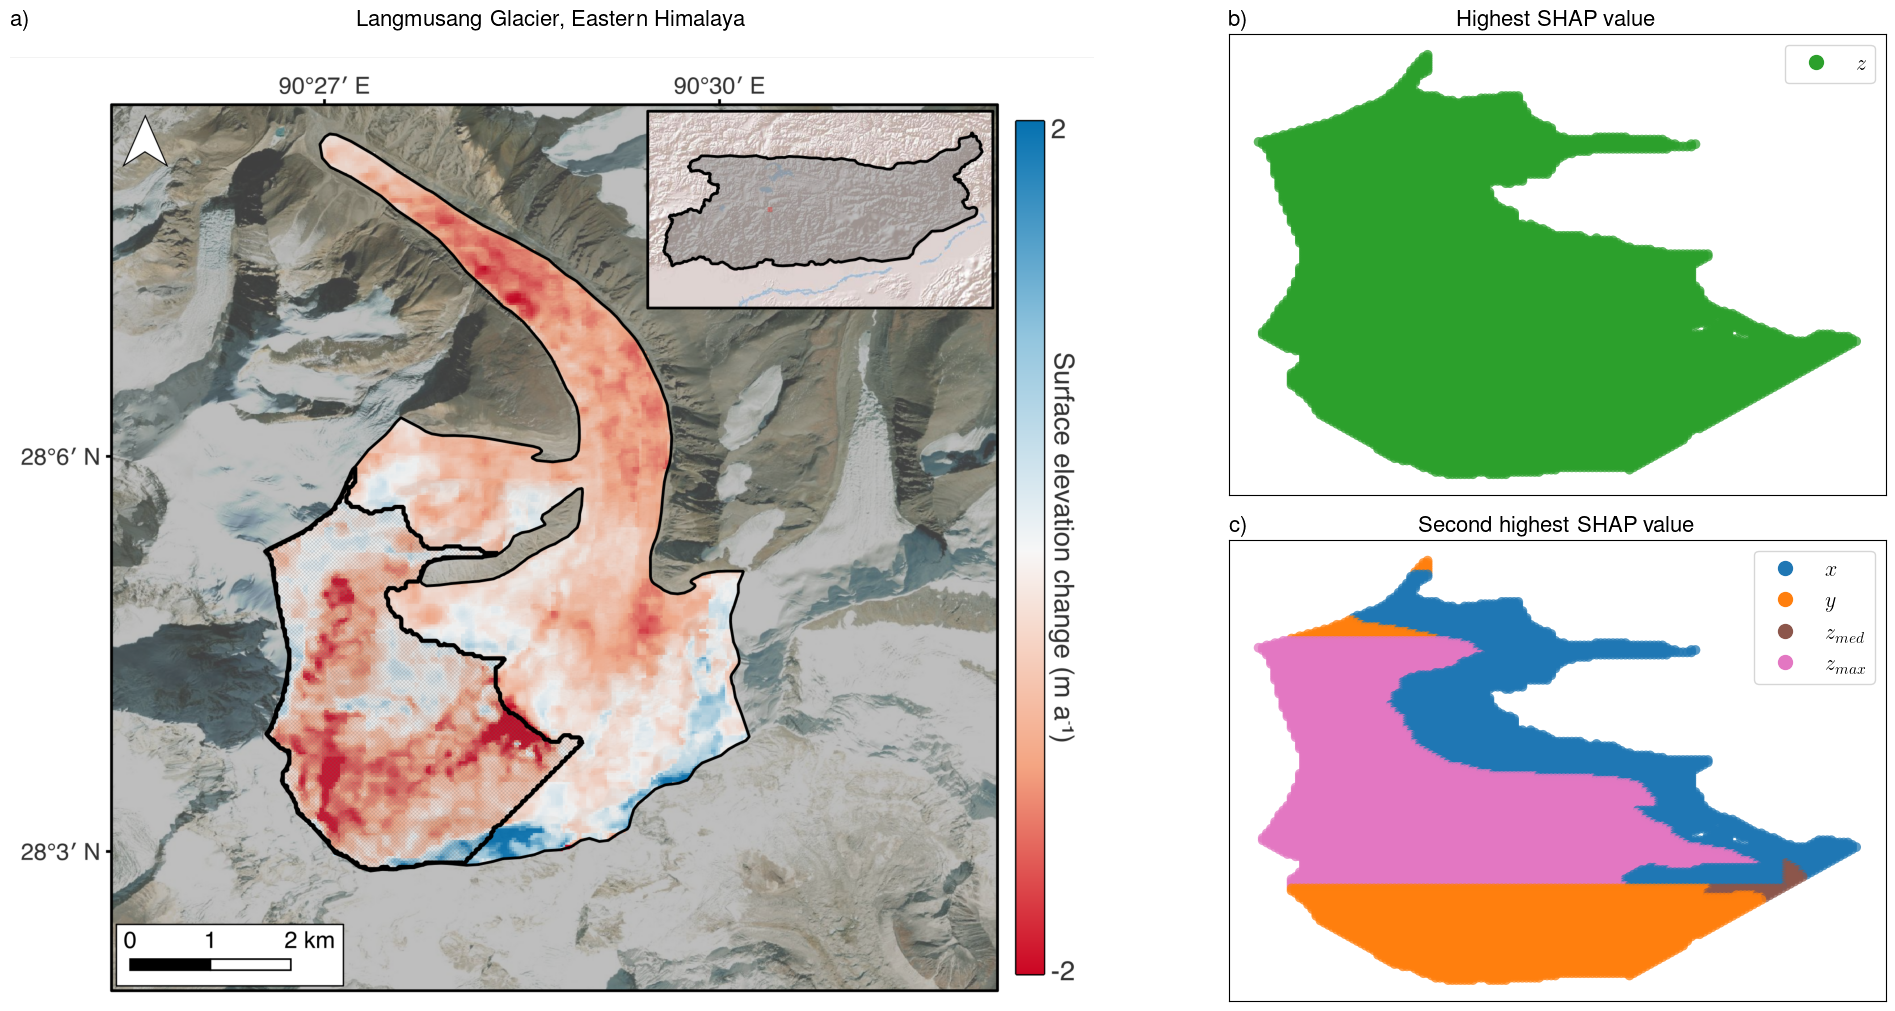

In [169]:
fig, ax = plot_spatial_shap_ehim(glacier1_test, shap_values1)
# fig, ax = plot_spatial_shap3(glacier1_test, shap_values1)

# plt.show()

In [166]:
def plot_spatial_shap_whim(X_test, shap_values):
    """
    Plot the three features with maximum SHAP values at each spatial location
    
    Parameters:
    -----------
    X_test : pandas DataFrame
        Test data containing x and y coordinates
    shap_values : shap._explanation.Explanation
        SHAP values from explainer
    """

    # # Find indices of the three features with maximum absolute SHAP values at each point
    top2_shap_idx = np.argsort(np.abs(shap_values), axis=1)[:, -2:]

    fig, axes = plt.subplot_mosaic([['a)', 'b)'], ['a)', 'c)']], figsize = (20,10), width_ratios = [2.5,1.5], sharex = False, sharey = False, layout = 'constrained')

    for label, ax in axes.items():
        ax.set_title(label, fontfamily='sans-serif', loc='left', fontsize=16)

    
    ax0 = axes['a)']
    try:
        img = mpimg.imread('./figures/whim_map_FINAL2.png')
    except FileNotFoundError:
        print("Image file not found. Please replace 'your_image.png' with a valid path to an image.")
        # Create a dummy image for demonstration if the file is not found
        img = np.random.rand(100, 100, 3)
    ax0.imshow(img)
    ax0.set_ymargin(-0.04)
    ax1 = axes['b)']
    ax2 = axes['c)']
    # print(img.shape)
    for i in range(2):
        if i == 0:
            ax = ax1
        else:
            ax = ax2
            
        feature_idx = top2_shap_idx[:, (1-i)]
        feature_values = np.array([shap_values[j, idx] for j, idx in enumerate(feature_idx)])
        feature_names = [features[idx] for idx in feature_idx]

        # Plot SHAP values
        # scatter1 = sns.scatterplot(x=X_test['x'], 
        #                             y=X_test['y'], 
        #                             hue=feature_values, 
        #                             ax=ax, 
        #                             palette='Greys',
        #                             # hue_norm=(-np.abs(feature_values).max(), np.abs(feature_values).max()),
        #                             s=50,
        #                             alpha=1,
        #                             edgecolor='none',
        #                             legend = False)
        
        # Plot feature with maximum impact
        scatter2 = sns.scatterplot(x=X_test['x'], 
                                    y=X_test['y'], 
                                    hue=feature_names, 
                                    ax=ax, 
                                    palette=cmap,
                                    s=50,
                                    alpha=0.75,
                                    edgecolor='none',
                                    hue_order = features,
                                    legend=False)
        
        legend_elements = [Line2D([0], [0], marker='o', color=cmap[feature], label=feature_names_read[feature], markerfacecolor=cmap[feature], markersize=10, linewidth = 0) for feature in features if feature in (set(feature_names))]
        ax.legend(handles = legend_elements, loc = 'upper left', prop={'size': 16})
        
        
    ax0.set_title('Toshain (Rupal) Glacier, Western Himalaya', fontsize = 16)
    # ax0.set_title('Langmusang Glacier, Eastern Himalaya', fontsize = 14)
    ax1.set_title('Highest SHAP value', fontsize = 16)
    ax2.set_title('Second highest SHAP value', fontsize = 16)
    
    ax1.set_xlabel('')
    ax2.set_xlabel('')
    ax1.set_ylabel('')
    ax2.set_ylabel('')
    ax1.set_xticks([])
    ax1.set_xticklabels([])
    ax1.set_yticks([])
    ax1.set_yticklabels([])
    ax2.set_xticks([])
    ax2.set_xticklabels([])
    ax2.set_yticks([])
    ax2.set_yticklabels([])
    # plt.tight_layout()
    ax0.axis('off')
    # # plt.show()

    save = True
    if save:
        plt.savefig('./figures/whim_shap_FINAL.png', bbox_inches='tight', dpi = 300)
    return fig, axes


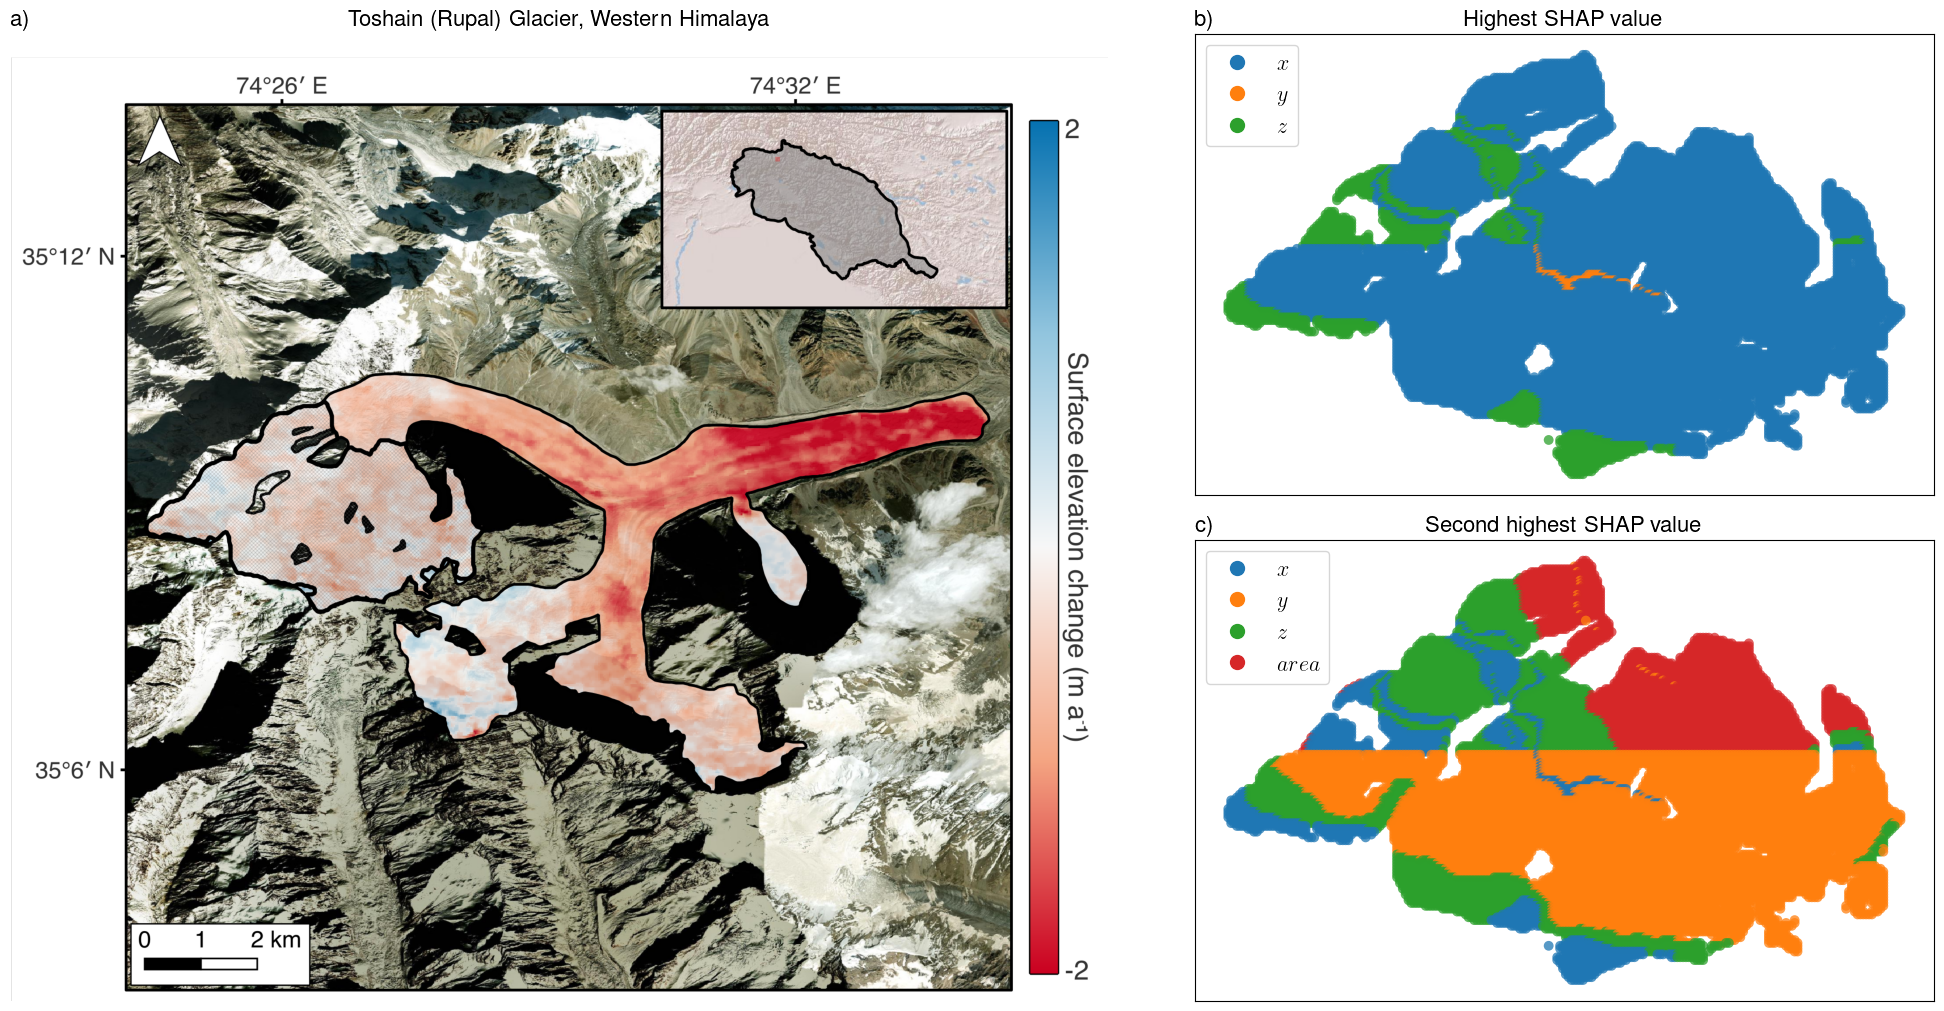

In [167]:
fig, ax = plot_spatial_shap_whim(glacier2_test, shap_values2)
# fig, ax = plot_spatial_shap3(glacier1_test, shap_values1)

# plt.show()